In [1]:
!pip install momentfm

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from momentfm import MOMENTPipeline
from pprint import pprint
import torch
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics
import warnings
warnings.filterwarnings('ignore')
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

In [3]:
df = pd.read_csv('data_final/combined_data.csv')
train_df = df[df['set'] == 'train']
train_df.drop(columns=['set'], inplace=True)
test_df = df[df['set'] == 'test']
test_df.drop(columns=['set'], inplace=True)

In [4]:
train_df_no_date = train_df.drop(columns=['Date'])
test_df_no_date = test_df.drop(columns=['Date'])

In [5]:
# create a train and test dataloader for forecasting H days ahead
H = 21
class TimeSeriesDataset(Dataset):
    def __init__(self, timeseries, H, fixed_length=512):
        self.timeseries = timeseries
        self.H = H
        self.fixed_length = fixed_length

        if len(self.timeseries.shape) == 1:
            # If the time series shape [n], reshape it to [1, n]
            self.timeseries = self.timeseries.reshape(1, -1)
                    
    def __len__(self):
        # Ensure that we don't go out of bounds
        return self.timeseries.shape[0] - self.H

    def __getitem__(self, idx):
        # Input: time series from the start up to idx+1
        start_idx = max(0, idx + 1 - self.fixed_length)
        input_series = self.timeseries[start_idx:idx + 1]
        
        # Padding: pad input_series to fixed_length with zeros on the left
        pad_len = self.fixed_length - input_series.shape[0]
        input_series = np.pad(input_series, ((pad_len, 0), (0, 0)), mode='constant')
        # input_series is [fixed_length, n_features], I need it in [n_features, fixed_length]
        input_series = input_series.T
        
        # Mask: 1s for the values we have, 0s for the values we don't have
        mask = np.ones(self.fixed_length)
        mask[:pad_len] = 0
        
        # Label: next H values after idx
        label = self.timeseries[idx + 1: idx + 1 + self.H]
        label = np.array(label).T
        
        return torch.tensor(input_series, dtype=torch.float32), torch.tensor(label, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [6]:
train_dataset = TimeSeriesDataset(train_df_no_date, H)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TimeSeriesDataset(test_df_no_date, H)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
for values in train_loader:
    print(f'values: {values[0].shape}')
    break

values: torch.Size([8, 6, 512])


# MOMENT

In [8]:
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': H,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [9]:
model.init()
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


## Fine-tuning the model using the training data

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 10

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")

100%|██████████| 156/156 [13:50<00:00,  5.32s/it]


Epoch 0: Train loss: 1527455.212


100%|██████████| 103/103 [09:28<00:00,  5.52s/it]

Epoch 1: Test MSE: 2483310.500 | Test MAE: 608.405


## Visualizing the model's predictions

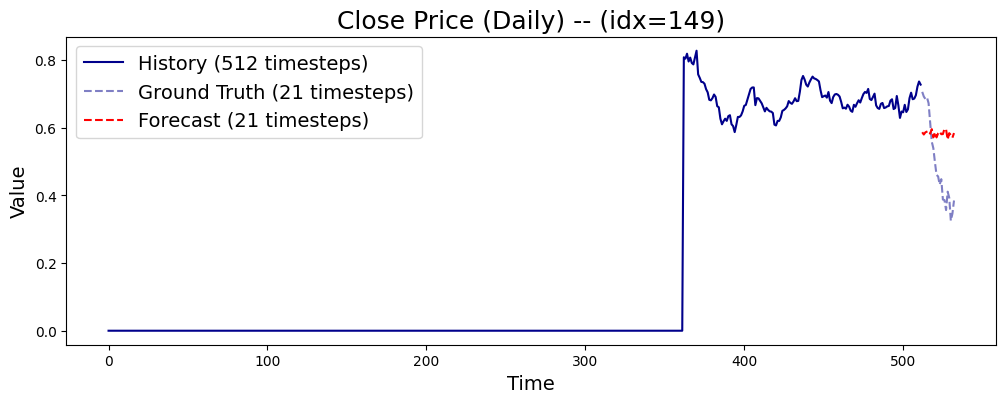

In [28]:
# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = 0
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (21 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (21 timesteps)', color='red', linestyle='--')

plt.title(f"Close Price (Daily) -- (idx={time_index})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Summary

As this model needs to be pretrained, and our training data is small, it did not succeed in predicting the test data with horizon $H=21$. We assume similar results for other horizon values.

# LSTM